# `CLEMnet` predictions on RL012
---
#### Overview
* Model for typical results figure and whatnot

In [1]:
# device = cuda.get_current_device()
# device.reset()

In [2]:
import clemnet

In [3]:
from pathlib import Path
import random
from datetime import datetime
from numba import cuda 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from skimage import io, exposure, color
from skimage import img_as_ubyte, img_as_float
from skimage.util import invert, crop
from skimage.transform import resize
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Set GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Set colormap
plt.set_cmap('magma')
plt.close();

# Ignore annoying Futurewarning from `gray2rgba`
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set ... AUTOTUNE?
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Organize training data
---

In [5]:
# 20200618_RL012
# --------------
# fps_src = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
fps_src = list(Path('/home/mabels/CLEMnet/data/RL012_blurred/').glob('*/*_*_*.png'))
# fps_tgt = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))
# path = '/home/mabels/CLEMnet/data/FASTEM/' 
# fps_src = list(Path(path).glob('*/*_*_*.png'))


# Get DataFrame for training
df_trn = clemnet.get_DataFrame(fps_src)

# Filter out all but 0th zoom level
df_trn = df_trn.loc[df_trn['zoom'] == 0]
# Filter out a test section
df_trn = df_trn.loc[df_trn['z'] != 7]

# Filter out outermost rows and columns
# where data is poor or does not exist
b = 4
df_trn_RL012 = pd.DataFrame()

# Must be done per section
for z, grp in df_trn.groupby('z'):
    df_trn_RL012 = df_trn_RL012.append(grp.loc[(grp['x'] > grp['x'].min()+b) &\
                                               (grp['y'] > grp['y'].min()+b) &\
                                               (grp['x'] < grp['x'].max()-b) &\
                                               (grp['y'] < grp['y'].max()-b)])

# k0 = 0
# k1 = k0*16
# n0 = 0+k1
# n1 = 16+k1
# df_trn_RL012 = df_trn_RL012[n0:n1]

print(df_trn_RL012)

                                                 source   z   y   x  zoom
12    /home/mabels/CLEMnet/data/RL012_blurred/1/10_1...   1  10  10     0
15    /home/mabels/CLEMnet/data/RL012_blurred/1/10_1...   1  10  11     0
17    /home/mabels/CLEMnet/data/RL012_blurred/1/10_1...   1  10  12     0
19    /home/mabels/CLEMnet/data/RL012_blurred/1/10_1...   1  10  13     0
21    /home/mabels/CLEMnet/data/RL012_blurred/1/10_1...   1  10  14     0
...                                                 ...  ..  ..  ..   ...
9516  /home/mabels/CLEMnet/data/RL012_blurred/10/34_...  10  34  29     0
9517  /home/mabels/CLEMnet/data/RL012_blurred/10/34_...  10  34  30     0
9518  /home/mabels/CLEMnet/data/RL012_blurred/10/34_...  10  34  31     0
9519  /home/mabels/CLEMnet/data/RL012_blurred/10/34_...  10  34  32     0
9520  /home/mabels/CLEMnet/data/RL012_blurred/10/34_...  10  34  33     0

[3340 rows x 5 columns]


In [6]:
# Combine and shuffle DataFrame
df_trn = pd.concat([df_trn_RL012])
df_trn = df_trn.sample(frac=1, random_state=1337).reset_index(drop=True)

# Set source and target filepaths
fps_src = df_trn['source'].values

# Preview
out = f"""\
Number of training images... {len(df_trn)}
--------""";print(out)
df_trn.sample(2)

Number of training images... 3340
--------


,source,z,y,x,zoom
600,/home/mabels/CLEMnet/data/RL012_blurred/3/33_1...,3,33,13,0
476,/home/mabels/CLEMnet/data/RL012_blurred/4/9_8_...,4,9,8,0


### Create training and validation datasets
First test with very limited dataset size

In [7]:
# Choose validation size
n_validation = int(0.2 * len(df_trn))

# Split into training and validation sets
fps_trn_src = fps_src[:-n_validation]
fps_val_src = fps_src[-n_validation:]

In [8]:
# Set training parameters
repeat = True
n_repetitions = 4
shape_src = [1024, 1024]
augment = True
AUGMENTATIONS = {
    'flip': 1,
    'rotate': 1,
    'crop': 0.,
    'elastic': 0.3,
    'invert': 0.,
    'contrast': 0.3,
    'brightness': 0.3,
    'noise': 0.,
}
pad = False
padding = tf.constant([[16, 16],
                       [16, 16],
                       [ 0,  0]])
batch_size = 16
n_cores = 4

# Create datasets
ds_trn = clemnet.create_dataset(fps_trn_src, shuffle=True, buffer_size=None,
                                repeat=repeat, n_repetitions=n_repetitions, shape_src=shape_src,
                                augment=augment, augmentations=AUGMENTATIONS,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)
# Get first batch for shape info
batch_EM = next(iter(ds_trn))

print(f"""\
Training dataset size..... {tf.data.experimental.cardinality(ds_trn).numpy()}
EM image shape............ {batch_EM.shape}""")

2021-11-25 17:20:32.371519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-25 17:20:34.236182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2021-11-25 17:20:34.236490: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-25 17:20:34.238586: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-25 17:20:34.240274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-25 17:20:34.240970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.

Training dataset size..... 668
EM image shape............ (16, 1024, 1024, 1)


### Preview dataset

In [9]:
# Loop through a batch size worth of images
batch_EM1 = next(iter(ds_trn))

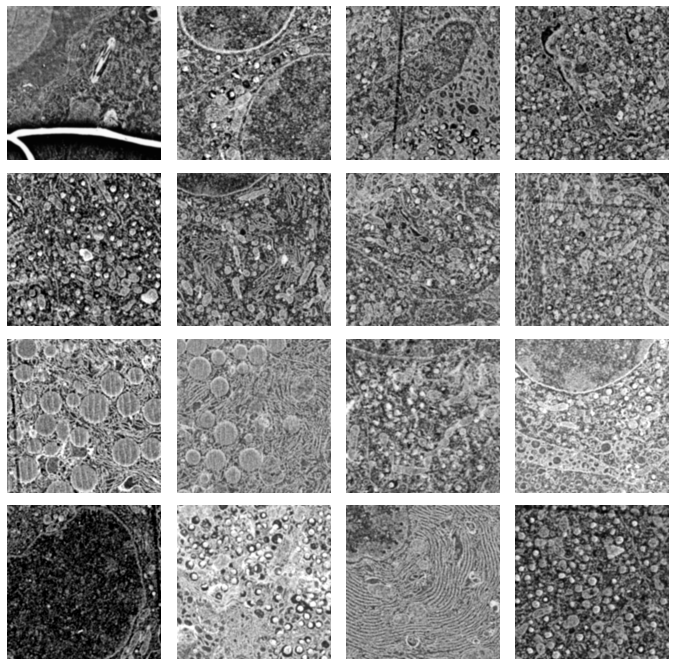

In [11]:
batch_EM = batch_EM1

# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*3, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

# c = 0.285/0.145
# batch_EM = tf.image.adjust_contrast(batch_EM, c)
# batch_EM = batch_EM+0.45-(0.58)
#print(batch_EM)
#batch_EM = tf.image.per_image_standardization(batch_EM)

for i in range(batch_size):

    # Fetch images from batch
    img_EM = batch_EM[i,:,:,0].numpy().astype(np.float32)

    # Create CLEM image
    img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
    
    # Set up mini gridspec
    gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace=0,
                                           subplot_spec=gs[i])
    ax1 = fig.add_subplot(gss[0])

    # Plot images
    ax1.imshow(img_EM, cmap='gray', vmin=0, vmax=1)

    # Aesthetics
    [ax.axis('off') for ax in [ax1]]

# plt.savefig('train.png', dpi=192)

### Preview dataset: test loop

In [ ]:
# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*3, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

# Loop through a batch size worth of images

stdd = 0
sstd = 0
p = 50
sstdplot = []
for j in range(p):
    stdd = 0

    for i in range(batch_size):
        batch_EM = next(iter(ds_trn))
#         c = 0.285/0.145
        #batch_EM = tf.image.adjust_contrast(batch_EM, c)
#         batch_EM = batch_EM+0.45-(0.58)
        #print(batch_EM)
        #batch_EM = tf.image.per_image_standardization(batch_EM)

        # Fetch images from batch
        img_EM = batch_EM[i,:,:,0].numpy().astype(np.float32)
        
        stdd += img_EM.mean()
        
        # Create CLEM image
        #img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)

        # Set up mini gridspec
        #gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace=0,
        #                                       subplot_spec=gs[i])
        #ax1 = fig.add_subplot(gss[0])

        # Plot images
        #ax1.imshow(img_EM, cmap='Greys', vmin=0, vmax=1)

        # Aesthetics
        #[ax.axis('off') for ax in [ax1]]

    # plt.savefig('train.png', dpi=192)
    sstd += (stdd/16)
    sstdplot.append(sstd/(j+1))
    
     
    print(sstd/(j+1))
    print(np.std(sstdplot))
    
print(sstd/p)
plt.plot(sstdplot)

0.45780439116060734
0.0
0.4707796396687627
0.006487624254077673
0.4599940227344632
0.0056713813027541235
0.45915790856815875
0.0051664592745990345
0.45280716456472875
0.00588911483244164
0.4560353799412648
0.005586210317616935
0.4591543802193233
0.005172723387002649
0.462525999173522
0.004948514764384931
0.4599831458181143
0.004665931158991684
0.4594355939887464
0.004427875537460376
0.461190410381691
0.0042415772277409084
0.4603563994945337
0.004062984662444355
0.4637581170894779
0.004034308852315937
0.46569230946313056
0.0041343064489209255
0.46216501853972053
0.004012678734300532
0.4607099751556234
0.003885260690971076
0.46153318470768523
0.003774087566808343
0.46333265971689896
0.003714445443219463
0.4625462854838636
0.0036337472074822693
0.46053035561635625
0.0035432048532023116
0.46063743141158264
0.003458559380780925
0.46170801838426007
0.0033826458748514032
0.4601467762790296
0.003312786851621737
0.4603575881725798
0.0032452388813641077
0.4605021904408932
0.0031807814687704705
0

In [18]:
%load_ext tensorboard

### Create model
Need better resolution for insulin prediction

In [19]:
def get_model(input_shape=(1024, 1024), crop=False, crop_width=None):
    """U-net-like convolutional neural network
    Parameters
    ----------
    input_shape : tuple
        Shape of input image data
    crop : bool
        Whether to include a cropping layer
    crop_width : int
        Number of pixels to crop from each border

    Returns
    -------
    model : `keras.Model`
        The model (duh)

    References
    ----------
    [1] U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    [2] Adapted from
        https://github.com/zhixuhao/unet/blob/master/model.py
    """
    # Create input layer
    input_shape = (*input_shape, 1) if len(input_shape) < 3 else input_shape
    inputs = layers.Input(shape=input_shape)

    # Set up keyword arguments for convolutional layers
    kwargs = {
        'activation': 'relu',
        'padding': 'same',
        'kernel_initializer': 'he_normal'
    }

    # Downsampling arm
    # ----------------
    # Block 1
    conv1 = layers.Conv2D(32, 3, **kwargs)(inputs)
    pool1 = layers.MaxPooling2D(2)(conv1)
    # Block 2
    conv2 = layers.Conv2D(64, 3, **kwargs)(pool1)
    pool2 = layers.MaxPooling2D(2)(conv2)
    # Block 3
    conv3 = layers.Conv2D(128, 3, **kwargs)(pool2)
    pool3 = layers.MaxPooling2D(2)(conv3)
    # Block 4
    conv4 = layers.Conv2D(256, 3, **kwargs)(pool3)
    pool4 = layers.MaxPooling2D(2)(conv4)
    # Block 5
    conv5 = layers.Conv2D(512, 3, **kwargs)(pool4)
    pool5 = layers.MaxPooling2D(2)(conv5)
    # Block 6
    conv6 = layers.Conv2D(1024, 3, **kwargs)(pool5)
    pool6 = layers.MaxPooling2D(2)(conv6)

    # Upsampling arm
    # --------------
    # Block 7
    conv7 = layers.Conv2D(1024, 3, **kwargs)(pool6)
    uppp7 = layers.UpSampling2D(2)(conv7)
    # Block 8
    merg8 = layers.concatenate([conv6, uppp7], axis=3)
    conv8 = layers.Conv2D(1024, 3, **kwargs)(merg8)
    uppp8 = layers.UpSampling2D(2)(conv8)
    # Block 9
    merg9 = layers.concatenate([conv5, uppp8], axis=3)
    conv9 = layers.Conv2D(512, 3, **kwargs)(merg9)
    uppp9 = layers.UpSampling2D(2)(conv9)
    # Block 10
    merg10 = layers.concatenate([conv4, uppp9], axis=3)
    conv10 = layers.Conv2D(256, 3, **kwargs)(merg10)
    conv10 = layers.Conv2D(2, 3, **kwargs)(conv10)

    # Additional upsampling
    uppp11 = layers.UpSampling2D(2)(conv10)

    # Output layer
    conv11 = layers.Conv2D(1, 1, activation='sigmoid')(uppp11)
    model = keras.Model(inputs=inputs, outputs=conv11)
    return model

In [ ]:
# Get input shape for model
input_shape = batch_EM.shape[1:-1]

# Get model
crop = pad
crop_width = 16
model = get_model(input_shape=input_shape,
                  crop=crop, crop_width=crop_width)
# model.summary()

## Testing
---

### Load weights

In [8]:
path = r"./weights/"
n = 0
for files in os.listdir(path):
    size = os.path.getsize('./weights/' + files)
    n = n+1
    print(f"""{n}.      {files}      {size}""")
    
#f = open("./logs/RL012_1024x1024_hoechst_20210928_192147/train/events.out.tfevents.1632849707.hpc29.289585.842640.v2", "r")
#print(f.read())    
        


1.      RL012_1024x1024_hoechst_20210910_134442.h5      173871032
2.      RL012_1024x1024_hoechst_20210910_164250.h5      173871032
3.      RL012_1024x1024_hoechst_20210913_104156.h5      173871032
4.      RL012_1024x1024_hoechst_20210913_141500.h5      173871032
5.      RL012_1024x1024_hoechst_20210913_154839.h5      173871056
6.      RL012_1024x1024_hoechst_20210913_164246.h5      173871032
7.      RL012_1024x1024_hoechst_20210913_230725.h5      173871032
8.      RL012_1024x1024_hoechst_20210914_101641.h5      173871032
9.      RL012_1024x1024_hoechst_20210914_232044.h5      173871032
10.      RL012_1024x1024_hoechst_20210916_141857.h5      173871056
11.      RL012_1024x1024_hoechst_20210917_135732.h5      173871056
12.      RL012_1024x1024_hoechst_20210927_180319.h5      173871056
13.      RL012_RL025_1024x1024_hoechst_20210930_203856.h5      173871056
14.      RL012_1024x1024_hoechst_20210927_184528_(val)loss: 0.206\0.23_(val)PCC_tf: 0.334\0.196.h5      173871056
15.      RL012_102

In [133]:
fp_weights = Path('./weights/RL012_1024x1024_hoechst_20210914_101641.h5')
model.load_weights(fp_weights.as_posix())

### Create test dataset

In [113]:
# # Get training data filepaths
path = '/home/mabels/CLEMnet/data/FASTEM/' 
fps_src = list(Path(path).glob('*/*_*_*.png'))
# fps_src = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))

# Get DataFrame for training
df_tst = clemnet.get_DataFrame(fps_src)

# Filter out all but 0th zoom level
df_tst = df_tst.loc[df_tst['zoom'] == 0]

# Filter out a section for testing
df_tst = df_tst.loc[df_tst['z'] == 1]

# Set source and target filepaths
fps_tst_src = df_tst['source'].values
print(df_tst)

                                                 source  z    y    x  zoom
12     /home/mabels/CLEMnet/data/FASTEM/1/100_100_0.png  1  100  100     0
13     /home/mabels/CLEMnet/data/FASTEM/1/100_101_0.png  1  100  101     0
14     /home/mabels/CLEMnet/data/FASTEM/1/100_102_0.png  1  100  102     0
15     /home/mabels/CLEMnet/data/FASTEM/1/100_103_0.png  1  100  103     0
16     /home/mabels/CLEMnet/data/FASTEM/1/100_104_0.png  1  100  104     0
...                                                 ... ..  ...  ...   ...
25448     /home/mabels/CLEMnet/data/FASTEM/1/9_83_0.png  1    9   83     0
25449     /home/mabels/CLEMnet/data/FASTEM/1/9_84_0.png  1    9   84     0
25450     /home/mabels/CLEMnet/data/FASTEM/1/9_85_0.png  1    9   85     0
25451     /home/mabels/CLEMnet/data/FASTEM/1/9_86_0.png  1    9   86     0
25452     /home/mabels/CLEMnet/data/FASTEM/1/9_87_0.png  1    9   87     0

[18911 rows x 5 columns]


In [114]:
# Create test dataset
ds_tst = clemnet.create_dataset(fps_tst_src, shuffle=True, buffer_size=None,
                                repeat=False, shape_src=shape_src, augment=False,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)

### Make predictions

In [115]:
# Loop through a batch size worth of images
# batch_EM = next(iter(ds_tst))

batch_EM = batch_EM1

c = 0.285/0.145
batch_EM = tf.image.adjust_contrast(batch_EM, c)
batch_EM = batch_EM+0.45-(0.58)
#print(batch_EM)
#batch_EM = tf.image.per_image_standardization(batch_EM)

# Make predictions
predictions = model.predict(batch_EM,
                            verbose=1)

1/1 [==============================] - 0s 3ms/step


### Preview predictions

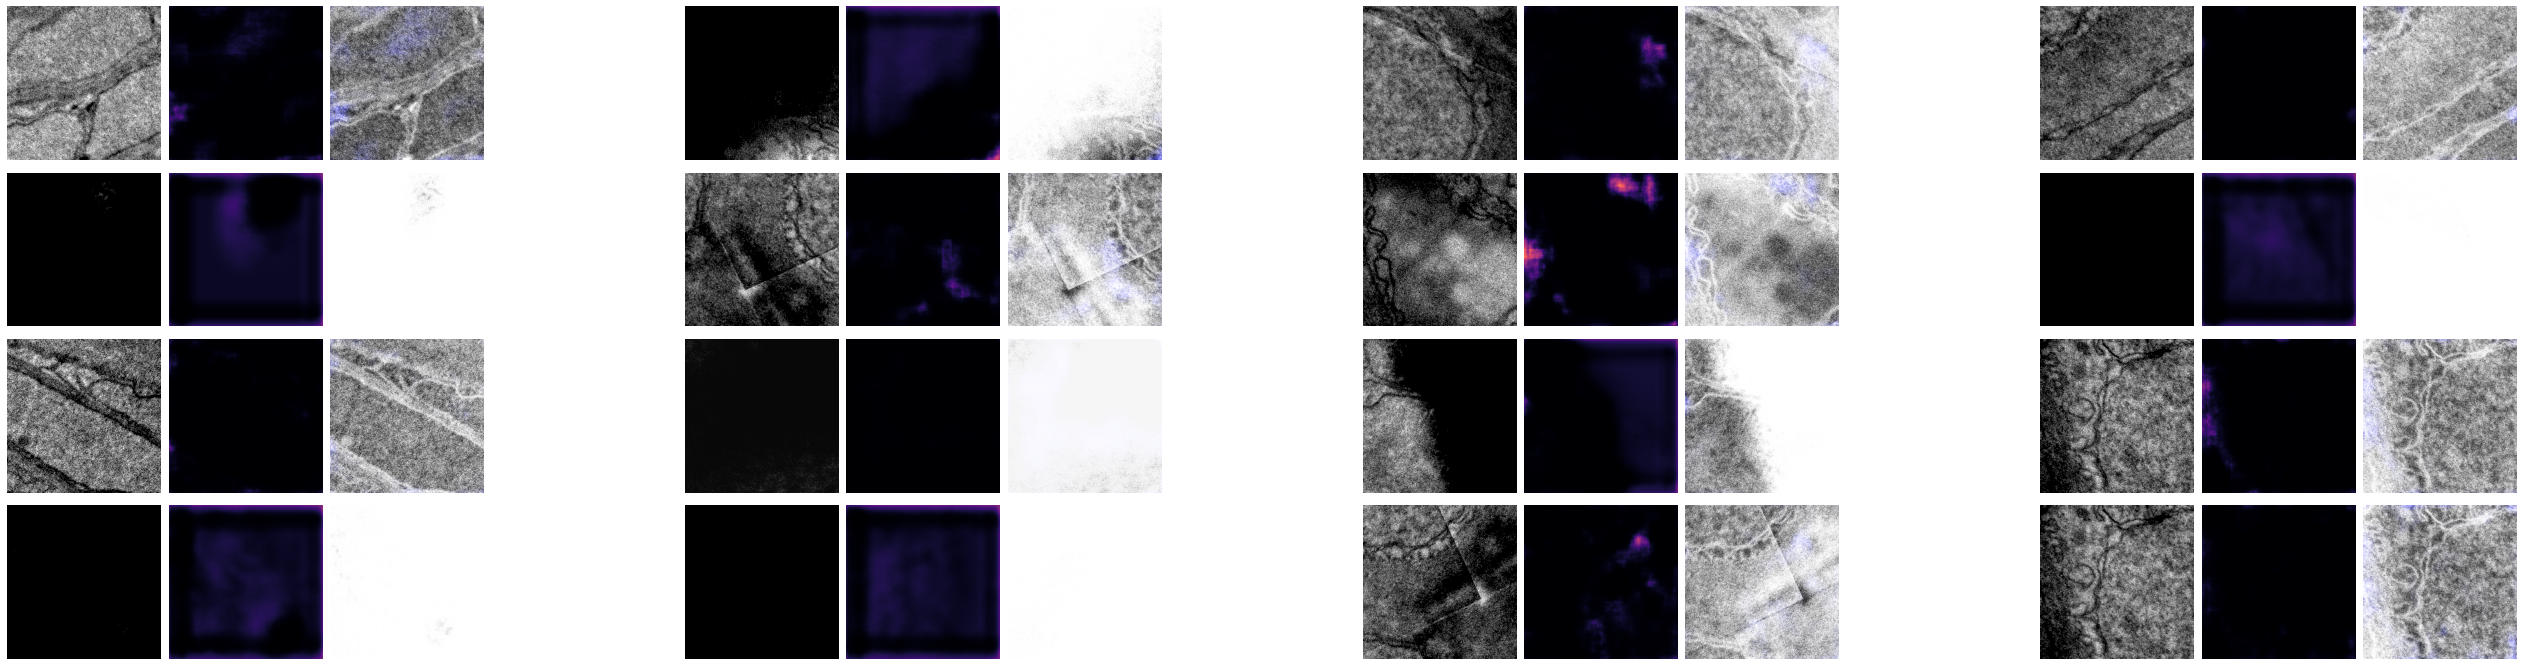

In [117]:
# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*12, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

for i in range(batch_size):

    # Fetch images from batch n
    img_EM = batch_EM[i, :, :, 0].numpy().astype(np.float32)  # (256, 256)
    img_PR = predictions[i, :, :, 0].astype(np.float32)       # (256, 256)

    # Upsample to fit EM
    img_PR = resize(img_PR, img_EM.shape)

    # Create CLEM images
    img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
    img_PR_ = clemnet.colorize(img_PR, clemnet.T_HOECHST)
    img_PREM = exposure.rescale_intensity(img_EM_+img_PR_, in_range=(0, 1))

    # Set up mini gridspec
    gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, wspace=0,
                                           subplot_spec=gs[i])
    ax1 = fig.add_subplot(gss[0])
    ax2 = fig.add_subplot(gss[1])
    ax3 = fig.add_subplot(gss[2])

    # Plot images
    ax1.imshow(img_EM, cmap='gray', vmin=0, vmax=1)
    ax2.imshow(img_PR, cmap='magma', vmin=0, vmax=1)
    ax3.imshow(img_PREM)

    # Aesthetics
    [ax.axis('off') for ax in [ax1, ax2, ax3]]

### Full section prediction

In [306]:
# Make figure
%matplotlib widget
ncols = df_tst['z'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 12),
                         sharex=True, sharey=True, squeeze=False)
axmap = {k:v for k,v in zip(df_tst['z'].unique(), axes.T)}

for z, df_sec in df_tst.groupby('z'):

    # Create dataset for section
    fps_src = df_sec['source']
    ds_section = clemnet.create_dataset(fps_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()

    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))
    
#     shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
#               (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])
#     print(shape)
    k=5
    shape = (k*batch_EM.shape[1],k*batch_EM.shape[2])
    print(shape)
    section_EM = np.empty(shape)
    print(f"{round(section_EM.nbytes/1000000)} MB")
    section_PR = np.empty(shape)

    # Loop through individual EM and FM tiles
    for (i, row), (batch_EM) in zip(df_sec.iterrows(), ds_section):
        # Make prediction
        pred = model.predict(batch_EM, verbose=0)

        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        print(x1)
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        # Populate section images
        crop_width = ((16, 16), (16, 16))
        section_EM[y1:y2, x1:x2] = crop(batch_EM[0,:,:,0],
                                        crop_width=crop_width, copy=True)
        section_FM[y1:y2, x1:x2] = crop(resize(batch_FM[0,:,:,0].numpy().astype(np.float32), batch_EM.shape[1:3]),
                                        crop_width=crop_width, copy=True)
        section_PR[y1:y2, x1:x2] = crop(resize(pred[0,:,:,0], batch_EM.shape[1:3]),
                                        crop_width=crop_width, copy=True)

#     # Colorize and overlay section images
#     section_PR_ = clemnet.colorize(section_PR/section_PR.max(), T=clemnet.T_RED)
#     section_EM_ = color.gray2rgba(invert(section_EM), alpha=True)
#     section_CLEM = exposure.rescale_intensity(section_EM_ + section_FM_, in_range=(0, 1))
#     section_PRED = exposure.rescale_intensity(section_EM_ + section_PR_, in_range=(0, 1))
#     # Plot
#     output_shape = [d//3 for d in section_CLEM.shape[:2]]
#     axmap[z][0].imshow(resize(section_CLEM, output_shape))
#     axmap[z][1].imshow(resize(section_PRED, output_shape))
# #     # Save
# #     fp = Path(f'RL010_S{z:03d}_CLEM.png')
# #     io.imsave(fp.as_posix(), section_CLEM)
# #     fp = Path(f'RL010_S{z:03d}_PRED.png')
# #     io.imsave(fp.as_posix(), section_PRED)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(5120, 5120)
210 MB
86016


TypeError: 'bool' object is not callable